# Классификация спама в электронной почте
Ссылка: https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv.

## Используемые инструменты
Библиотеки:
 - pandas (Version: 2.3.1).
 - matplotlib (Version: 3.10.5).
 - time (модуль из стандартной библиотеки).
 - random (модуль из стандартной библиотеки).
 - warnings (модуль из стандартной библиотеки).
 - gc (модуль из стандартной библиотеки).
 - pympler (Version: 1.1).
 - scikit-learn (Version: 1.8.0).
 - catboost (Version: 1.2.8).

Таблица:
 - emails.csv.

## Содержание таблицы
В таблице 3002 столбца. В первом столбце указано имя отправителя. Чтобы защитить конфиденциальность, вместо имён получателей указаны номера. В последнем столбце указаны метки для прогнозирования: 1 - спам, 0 - не спам. Остальные 3000 столбцов содержат 3000 наиболее часто встречающихся слов во всех электронных письмах после исключения неалфавитных символов/слов. В каждой строке указано количество вхождений каждого слова (столбца) в этом электронном письме (строке). Таким образом, информация обо всех 5172 электронных письмах хранится в компактном датафрейме, а не в отдельных текстовых файлах.

## Подготовка и анализ данных
### Загрузка всех инструментов
Загрузка всех библиотек и функций/классов, используемых в работе. Для проверки качества моделей будут использоваться следующие метрики: матрица ошибок, LogLoss, ROC-AUC, PR-AUC. Задание "random_seed" для воспроизводства результатов. Игнорирование предупреждений.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import time
import random
import warnings
import gc
from pympler import asizeof

from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.metrics import (confusion_matrix, log_loss, classification_report, roc_auc_score, roc_curve, RocCurveDisplay,
                             precision_recall_curve, PrecisionRecallDisplay, average_precision_score)
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.naive_bayes import BernoulliNB, CategoricalNB, ComplementNB, GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC, NuSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier,
                              GradientBoostingClassifier, HistGradientBoostingClassifier, RandomForestClassifier)

from catboost import CatBoostClassifier, Pool, cv
from catboost.utils import get_confusion_matrix

random_seed = 1
random.seed(a = random_seed)
warnings.filterwarnings('ignore')

Загрузка таблицы и просмотр первых и последних 5-ти строк.

In [2]:
emails = pd.read_csv('emails.csv')
emails

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,Email 5168,2,2,2,3,0,0,32,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,Email 5169,35,27,11,2,6,5,151,4,3,...,0,0,0,0,0,0,0,1,0,0
5169,Email 5170,0,0,1,1,0,0,11,0,0,...,0,0,0,0,0,0,0,0,0,1
5170,Email 5171,2,7,1,0,2,1,28,2,0,...,0,0,0,0,0,0,0,1,0,1


### Первичный анализ таблицы
Статистическое описание колонки с именами почтовых отправителей.

In [3]:
emails.describe(include = 'object')

,Email No.
count,5172
unique,5172
top,Email 1
freq,1


Каждому письму соответствует уникальный отправитель. Колонка важной информации для классификации спама не несёт и её можно удалить.

In [4]:
emails = emails.drop(columns = ['Email No.'])
emails

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0,0,1,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,13,24,6,6,2,102,1,27,18,...,0,0,0,0,0,0,0,1,0,0
2,0,0,1,0,0,0,8,0,0,4,...,0,0,0,0,0,0,0,0,0,0
3,0,5,22,0,5,1,51,2,10,1,...,0,0,0,0,0,0,0,0,0,0
4,7,6,17,1,5,2,57,0,9,3,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,2,2,2,3,0,0,32,0,0,5,...,0,0,0,0,0,0,0,0,0,0
5168,35,27,11,2,6,5,151,4,3,23,...,0,0,0,0,0,0,0,1,0,0
5169,0,0,1,1,0,0,11,0,0,1,...,0,0,0,0,0,0,0,0,0,1
5170,2,7,1,0,2,1,28,2,0,8,...,0,0,0,0,0,0,0,1,0,1


Явное определение имени таргета для последующих расчётов.

In [5]:
target = 'Prediction'

Проверка на наличие колонок с пропусками и вывод таких колонок.

In [6]:
for column in emails.columns:
    if emails[column].isna().any():
        print(column)
print('--------')

--------


Как видно - пропущенных значений вообще нет.

Каждый признак - количество вхождений данного слова в текст письма. Поскольку письма бывают разной длины - большую информацию будет нести не количество слов, а их частота относительно других слов. Таким образом, следует преобразовать все значения в таблице как отношения количеств вхождений слов к общей сумме всех слов в письме.

In [7]:
emails_rel = emails.T
for col in emails_rel.columns:
    if emails_rel[col].sum() > 0:
        emails_rel[col] = emails_rel[col] / emails_rel[col].sum()
emails_rel = emails_rel.T
emails_rel[target] = (emails_rel[target] > 0).astype(int)
emails_rel

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,0.000000,0.000000,0.018868,0.000000,0.000000,0.000000,0.037736,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
1,0.003631,0.005901,0.010894,0.002724,0.002724,0.000908,0.046300,0.000454,0.012256,0.008171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000454,0.0,0
2,0.000000,0.000000,0.008850,0.000000,0.000000,0.000000,0.070796,0.000000,0.000000,0.035398,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
3,0.000000,0.004907,0.021590,0.000000,0.004907,0.000981,0.050049,0.001963,0.009814,0.000981,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
4,0.006512,0.005581,0.015814,0.000930,0.004651,0.001860,0.053023,0.000000,0.008372,0.002791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000930,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.003960,0.003960,0.003960,0.005941,0.000000,0.000000,0.063366,0.000000,0.000000,0.009901,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0
5168,0.011909,0.009187,0.003743,0.000681,0.002042,0.001701,0.051378,0.001361,0.001021,0.007826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000340,0.0,0
5169,0.000000,0.000000,0.005587,0.005587,0.000000,0.000000,0.061453,0.000000,0.000000,0.005587,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1
5170,0.002538,0.008883,0.001269,0.000000,0.002538,0.001269,0.035533,0.002538,0.000000,0.010152,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001269,0.0,1


Соотношение между классами таргета.

In [8]:
emails_rel[target].value_counts()

Prediction
0    3672
1    1500
Name: count, dtype: int64

Писем, которые необходимо отмечать как спам, более чем в 2 раза меньше, чем обычных. В случае сильного дисбаланса в классах таргета необходимо в первую очередь уменьшать вероятность FN-исхода, то есть оптимизировать метрику Recall. Поскольку идентификация спама не является критической задачей и данный класс не редок в данных - можно в качестве основных метрих при дальнейшем обучении, помимо матрицы ошибок и LogLoss, использовать F1-меру или P4-меру. Далее при проверках качества на тестовых данных будут рассчитываться дополнительные метрики: Precision, Recall, Specificity, NPV, F1-мера и P4-мера.

### Основные метрики
Функции для расчёта выбранных метрик.

In [9]:
def Precision(tn, fp, fn, tp):
    return round(tp / (tp + fp + 1e-15), 6)
def Recall(tn, fp, fn, tp):
    return round(tp / (tp + fn + 1e-15), 6)
def Specificity(tn, fp, fn, tp):
    return round(tn / (tn + fp + 1e-15), 6)
def NPV(tn, fp, fn, tp):
    return round(fn / (tn + fn + 1e-15), 6)
def F1_score(tn, fp, fn, tp):
    return round(2 * tp / (2 * tp + fp + fn + 1e-15), 6)
def P4_score(tn, fp, fn, tp):
    return round(4 * tp * tn / (4 * tp * tn + (tp + tn) * (fp + fn) + 1e-15), 6)

### Проверка на мультиколлинеарность
Создание матрицы линейных корреляций между всеми параметрами.

In [10]:
multicorr = emails_rel.corr()
multicorr

,the,to,ect,and,for,of,a,you,hou,in,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
the,1.000000,0.132237,-0.209296,0.241947,-0.113356,0.188543,0.066889,0.040086,0.031083,0.174598,...,-0.021946,-0.007979,0.044491,-0.011154,0.011928,-0.007410,0.047613,0.022046,0.008755,-0.205290
to,0.132237,1.000000,-0.141674,0.084689,-0.218774,0.084524,0.005821,0.096734,-0.000460,0.134113,...,-0.011684,0.023168,0.023457,-0.002134,-0.011417,0.019581,0.010105,0.100499,0.008857,-0.022319
ect,-0.209296,-0.141674,1.000000,-0.205800,0.056344,-0.182165,-0.301343,-0.101627,0.281770,-0.242091,...,0.036244,-0.001368,-0.011789,-0.023185,-0.021143,-0.001050,-0.024470,-0.053802,-0.014875,-0.053163
and,0.241947,0.084689,-0.205800,1.000000,-0.175017,0.141157,0.202622,0.084372,0.002176,0.189041,...,-0.018218,-0.019401,0.011943,0.002252,0.037164,-0.011392,0.012603,0.034451,-0.001694,0.100608
for,-0.113356,-0.218774,0.056344,-0.175017,1.000000,-0.179038,-0.133723,-0.126104,-0.065897,-0.328211,...,-0.013864,-0.037299,-0.020390,-0.030221,0.007018,0.020009,-0.010654,-0.163336,0.015542,-0.282937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
military,-0.007410,0.019581,-0.001050,-0.011392,0.020009,-0.006750,-0.030502,-0.014810,-0.010723,0.015218,...,-0.001012,-0.001543,-0.000389,0.002219,-0.000517,1.000000,-0.000959,-0.005085,-0.001178,0.040624
allowing,0.047613,0.010105,-0.024470,0.012603,-0.010654,0.009345,-0.009946,0.017027,-0.008579,0.043836,...,-0.001946,-0.002967,-0.003090,-0.000628,0.019792,-0.000959,1.000000,-0.009688,-0.002705,-0.009367
ff,0.022046,0.100499,-0.053802,0.034451,-0.163336,0.346421,-0.047051,-0.022998,-0.075778,0.060514,...,-0.012131,-0.011409,0.042433,0.037171,0.007839,-0.005085,-0.009688,1.000000,0.016999,0.134444
dry,0.008755,0.008857,-0.014875,-0.001694,0.015542,0.008363,-0.016274,-0.015706,0.004115,0.009105,...,-0.002003,-0.001569,-0.003181,0.020622,-0.002183,-0.001178,-0.002705,0.016999,1.000000,-0.014425


Список пар признаков, линейная корреляция которых превышает 0.4 по модулю. В случае, если качество обучения моделей будет недостаточным - можно поднять порог отсечения признаков для меньшего количества последующих удалений признаков.

In [11]:
mc_couples = list()
mc_threshold = 0.4
for i in range(1, multicorr.shape[0] - 1):
    for j in range(i):
        if abs(multicorr.iloc[i, j]) > mc_threshold:
            mc_couples.append((multicorr.index[i], multicorr.index[j]))
print('Количество пар:', len(mc_couples))
print('Первые 5 пар:', mc_couples[:5])

Количество пар: 3667
Первые 5 пар: [('this', 'is'), ('enron', 'on'), ('i', 'for'), ('i', 'in'), ('your', 'you')]


Формирование множества признаков на удаление, которые имеют максимальную суммарную корреляцию с остальными признаками.

In [12]:
feats_del = set()
mc_couples_copy = [el for el in mc_couples]
while len(mc_couples_copy) > 0:
    feat_1 = mc_couples_copy[0][0]
    feat_2 = mc_couples_copy[0][1]
    corr_sum_1 = multicorr[feat_1].abs().sum()
    corr_sum_2 = multicorr[feat_2].abs().sum()
    feat_del = feat_1 if corr_sum_1 > corr_sum_2 else feat_2
    feats_del.add(feat_del)
    mc_couples_copy = [el for el in mc_couples_copy if feat_del not in el]
print('Количесвто признаков на удаление:', len(feats_del))

Количесвто признаков на удаление: 1343


Удаление лишних признаков.

In [13]:
emails_rel_corr = emails_rel.drop(columns = feats_del)
emails_rel_corr

,to,a,hou,in,this,be,that,have,with,your,...,remains,ifhsc,enhancements,connevey,valued,infrastructure,military,allowing,dry,Prediction
0,0.000000,0.037736,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,0.005901,0.046300,0.012256,0.008171,0.000000,0.001816,0.000908,0.000000,0.000908,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0.000000,0.070796,0.000000,0.035398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.004907,0.050049,0.009814,0.000981,0.001963,0.001963,0.000000,0.000981,0.000981,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.005581,0.053023,0.008372,0.002791,0.001860,0.007442,0.000000,0.001860,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.003960,0.063366,0.000000,0.009901,0.000000,0.001980,0.000000,0.001980,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5168,0.009187,0.051378,0.001021,0.007826,0.001021,0.003403,0.002042,0.000681,0.002042,0.000340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
5169,0.000000,0.061453,0.000000,0.005587,0.005587,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
5170,0.008883,0.035533,0.000000,0.010152,0.001269,0.001269,0.000000,0.000000,0.002538,0.001269,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


### Разделение переменных
Разделение данных из таблицы "emails_rel_corr" на независимые переменные (признаки) и зависимую переменную (таргет).

In [14]:
X = emails_rel_corr.drop(columns = [target])
y = emails_rel_corr[target]

Разделение данных на train\test в пропорции 80%/20%.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_seed)

## Обучение одиночных моделей
Формирование словаря с самыми разнообразными одиночными моделями классификации и различными их гиперпараметрами для последующей тренировки и их сравнения. Гиперпараметры (количество итераций) выбраны таким образом, чтобы все модели успевали обучаться за разумное время.

In [16]:
skl_models = {
    'LogisticRegression_l2_lbfgs': LogisticRegression(l1_ratio = 0, solver = 'lbfgs', random_state = random_seed),
    'LogisticRegression_l1_liblinear': LogisticRegression(l1_ratio = 1, solver = 'liblinear', random_state = random_seed),
    'LogisticRegression_l2_liblinear': LogisticRegression(l1_ratio = 0, solver = 'liblinear', random_state = random_seed),
    'LogisticRegression_l2_newton-cg': LogisticRegression(l1_ratio = 0, solver = 'newton-cg', random_state = random_seed),
    'LogisticRegression_l2_newton-ch': LogisticRegression(l1_ratio = 0, solver = 'newton-cholesky', random_state = random_seed),
    'LogisticRegression_l2_sag': LogisticRegression(l1_ratio = 0, solver = 'sag', random_state = random_seed),
    'LogisticRegression_l1_saga': LogisticRegression(l1_ratio = 1, solver = 'saga', random_state = random_seed, max_iter = 500),
    'LogisticRegression_l2_saga': LogisticRegression(l1_ratio = 0, solver = 'saga', random_state = random_seed),
    'Perceptron_l1': Perceptron(penalty = 'l1', random_state = random_seed, n_jobs = -1),
    'Perceptron_l2': Perceptron(penalty = 'l2', random_state = random_seed, n_jobs = -1),
    'RidgeClassifier_svd': RidgeClassifier(solver = 'svd', random_state = random_seed),
    'RidgeClassifier_ch': RidgeClassifier(solver = 'cholesky', random_state = random_seed),
    'RidgeClassifier_lsqr': RidgeClassifier(solver = 'lsqr', random_state = random_seed),
    'RidgeClassifier_sc': RidgeClassifier(solver = 'sparse_cg', random_state = random_seed),
    'RidgeClassifier_sag': RidgeClassifier(solver = 'sag', random_state = random_seed),
    'RidgeClassifier_saga': RidgeClassifier(solver = 'saga', random_state = random_seed),
    'RidgeClassifier_lbfgs': RidgeClassifier(solver = 'lbfgs', positive = True, random_state = random_seed),
    'SGDClassifier_hinge': SGDClassifier(loss = 'hinge', random_state = random_seed, n_jobs = -1),
    'SGDClassifier_ll': SGDClassifier(loss = 'log_loss', random_state = random_seed, n_jobs = -1),
    'SGDClassifier_mh': SGDClassifier(loss = 'modified_huber', random_state = random_seed, n_jobs = -1),
    'SGDClassifier_perceptron': SGDClassifier(loss = 'perceptron', random_state = random_seed, n_jobs = -1),
    'SGDClassifier_ei': SGDClassifier(loss = 'epsilon_insensitive', random_state = random_seed, n_jobs = -1),
    'BernoulliNB': BernoulliNB(), 'CategoricalNB': CategoricalNB(), 'ComplementNB': ComplementNB(),
    'GaussianNB': GaussianNB(), 'MultinomialNB': MultinomialNB(),
    'KNeighborsClassifier_u_bt': KNeighborsClassifier(weights = 'uniform', algorithm = 'ball_tree', n_jobs = -1),
    'KNeighborsClassifier_d_bt': KNeighborsClassifier(weights = 'distance', algorithm = 'ball_tree', n_jobs = -1),
    'KNeighborsClassifier_u_kdt': KNeighborsClassifier(weights = 'uniform', algorithm = 'kd_tree', n_jobs = -1),
    'KNeighborsClassifier_d_kdt': KNeighborsClassifier(weights = 'distance', algorithm = 'kd_tree', n_jobs = -1),
    'KNeighborsClassifier_u_b': KNeighborsClassifier(weights = 'uniform', algorithm = 'brute', n_jobs = -1),
    'KNeighborsClassifier_d_b': KNeighborsClassifier(weights = 'distance', algorithm = 'brute', n_jobs = -1),
    'NearestCentroid_e': NearestCentroid(metric = 'euclidean'),
    'NearestCentroid_m': NearestCentroid(metric = 'manhattan'),
    'RadiusNeighborsClassifier_u_bt': RadiusNeighborsClassifier(weights = 'uniform', algorithm = 'ball_tree', n_jobs = -1),
    'RadiusNeighborsClassifier_d_bt': RadiusNeighborsClassifier(weights = 'distance', algorithm = 'ball_tree', n_jobs = -1),
    'RadiusNeighborsClassifier_u_kdt': RadiusNeighborsClassifier(weights = 'uniform', algorithm = 'kd_tree', n_jobs = -1),
    'RadiusNeighborsClassifier_d_kdt': RadiusNeighborsClassifier(weights = 'distance', algorithm = 'kd_tree', n_jobs = -1),
    'RadiusNeighborsClassifier_u_b': RadiusNeighborsClassifier(weights = 'uniform', algorithm = 'brute', n_jobs = -1),
    'RadiusNeighborsClassifier_d_b': RadiusNeighborsClassifier(weights = 'distance', algorithm = 'brute', n_jobs = -1),
    'MLPClassifier_l_lbfgs': MLPClassifier(activation = 'logistic', solver = 'lbfgs', random_state = random_seed),
    'MLPClassifier_l_sgd': MLPClassifier(activation = 'logistic', solver = 'sgd', random_state = random_seed),
    'MLPClassifier_l_adam': MLPClassifier(activation = 'logistic', solver = 'adam', random_state = random_seed, max_iter = 2000),
    'MLPClassifier_t_lbfgs': MLPClassifier(activation = 'tanh', solver = 'lbfgs', random_state = random_seed, max_iter = 2000),
    'MLPClassifier_t_sgd': MLPClassifier(activation = 'tanh', solver = 'sgd', random_state = random_seed),
    'MLPClassifier_t_adam': MLPClassifier(activation = 'tanh', solver = 'adam', random_state = random_seed, max_iter = 1000),
    'LinearSVC_l2_hinge': LinearSVC(penalty = 'l2', loss = 'hinge',
                                    class_weight = 'balanced', random_state = random_seed),
    'LinearSVC_l1_shinge': LinearSVC(penalty = 'l1', loss = 'squared_hinge',
                                     class_weight = 'balanced', random_state = random_seed, max_iter = 5000),
    'LinearSVC_l2_shinge': LinearSVC(penalty = 'l2', loss = 'squared_hinge',
                                     class_weight = 'balanced', random_state = random_seed),
    'NuSVC_linear': NuSVC(kernel = 'linear', class_weight = 'balanced', random_state = random_seed),
    'NuSVC_poly': NuSVC(kernel = 'poly', class_weight = 'balanced', random_state = random_seed),
    'NuSVC_rbf': NuSVC(kernel = 'rbf', class_weight = 'balanced', random_state = random_seed),
    'NuSVC_sigmoid': NuSVC(kernel = 'sigmoid', class_weight = 'balanced', random_state = random_seed),
    'SVC_linear': SVC(kernel = 'linear', class_weight = 'balanced', random_state = random_seed),
    'SVC_poly': SVC(kernel = 'poly', class_weight = 'balanced', random_state = random_seed),
    'SVC_rbf': SVC(kernel = 'rbf', class_weight = 'balanced', random_state = random_seed),
    'SVC_sigmoid': SVC(kernel = 'sigmoid', class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_gini_3': DecisionTreeClassifier(criterion = 'gini', max_depth = 3,
                                                            class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_entr_3': DecisionTreeClassifier(criterion = 'entropy', max_depth = 3,
                                                            class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_ll_3': DecisionTreeClassifier(criterion = 'log_loss', max_depth = 3,
                                                          class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_gini_7': DecisionTreeClassifier(criterion = 'gini', max_depth = 7,
                                                            class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_entr_7': DecisionTreeClassifier(criterion = 'entropy', max_depth = 7,
                                                            class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_ll_7': DecisionTreeClassifier(criterion = 'log_loss', max_depth = 7,
                                                          class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_gini_11': DecisionTreeClassifier(criterion = 'gini', max_depth = 11,
                                                             class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_entr_11': DecisionTreeClassifier(criterion = 'entropy', max_depth = 11,
                                                             class_weight = 'balanced', random_state = random_seed),
    'DecisionTreeClassifier_ll_11': DecisionTreeClassifier(criterion = 'log_loss', max_depth = 11,
                                                           class_weight = 'balanced', random_state = random_seed)
}

Тренировка всех моделей из "skl_models" в отдельном словаре "skl_models_fit" с отслеживанием времени обучения.

In [17]:
skl_models_fit = dict()
start = time.perf_counter()
for model in skl_models:
    time1 = time.perf_counter()
    skl_models_fit[model] = skl_models[model].fit(X_train, y_train)
    print(f'"{model}", {time.perf_counter() - time1} секунд')
print('Суммарное время обучения моделей:', time.perf_counter() - start, 'секунд')

"LogisticRegression_l2_lbfgs", 0.10333160002483055 секунд
"LogisticRegression_l1_liblinear", 0.18345930002396926 секунд
"LogisticRegression_l2_liblinear", 0.07832799997413531 секунд
"LogisticRegression_l2_newton-cg", 0.20281549997162074 секунд
"LogisticRegression_l2_newton-ch", 0.9815825000405312 секунд
"LogisticRegression_l2_sag", 1.8793279999517836 секунд
"LogisticRegression_l1_saga", 24.533505700004753 секунд
"LogisticRegression_l2_saga", 1.2664906999561936 секунд
"Perceptron_l1", 0.5369838000042364 секунд
"Perceptron_l2", 0.21678499999688938 секунд
"RidgeClassifier_svd", 3.398872699995991 секунд
"RidgeClassifier_ch", 0.2848760999622755 секунд
"RidgeClassifier_lsqr", 0.12153780000517145 секунд
"RidgeClassifier_sc", 0.12403920001816005 секунд
"RidgeClassifier_sag", 0.7925771999871358 секунд
"RidgeClassifier_saga", 1.3019705000333488 секунд
"RidgeClassifier_lbfgs", 0.11985809996258467 секунд
"SGDClassifier_hinge", 0.6984234999981709 секунд
"SGDClassifier_ll", 0.5851261999923736 секунд

Расчёт элементов матрицы ошибок и метрики LogLoss для каждой модели из "skl_models_fit".

In [18]:
tn_m = dict()
fp_m = dict()
fn_m = dict()
tp_m = dict()
logloss_m = dict()
for model in skl_models_fit:
    y_pred = skl_models_fit[model].predict(X_test)
    (tn, fp, fn, tp) = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel().tolist()
    tn_m[model], fp_m[model], fn_m[model], tp_m[model] = tn, fp, fn, tp
    logloss_m[model] = log_loss(y_true = y_test, y_pred = y_pred)

Расчёт метрик на тестовых данных и формирование общей таблицы с её сохранением, где индекс - модель, столбец - метрика.

In [19]:
results_m = pd.DataFrame([tn_m, fp_m, fn_m, tp_m, logloss_m], index = ['TN', 'FP', 'FN', 'TP', 'LogLoss']).T
results_m['Precision'] = Precision(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m['Recall'] = Recall(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m['Specificity'] = Specificity(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m['NPV'] = NPV(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m['F1-score'] = F1_score(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m['P4-score'] = P4_score(tn = results_m['TN'], fp = results_m['FP'], fn = results_m['FN'], tp = results_m['TP'])
results_m.to_csv('results/results_models.csv', sep = ',', index_label = 'Single_models')
results_m

,TN,FP,FN,TP,LogLoss,Precision,Recall,Specificity,NPV,F1-score,P4-score
LogisticRegression_l2_lbfgs,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l1_liblinear,704.0,15.0,274.0,42.0,10.064363,0.736842,0.132911,0.979138,0.280164,0.225201,0.354250
LogisticRegression_l2_liblinear,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l2_newton-cg,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l2_newton-ch,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
DecisionTreeClassifier_entr_7,535.0,184.0,42.0,274.0,7.870402,0.598253,0.867089,0.744089,0.072790,0.708010,0.762304
DecisionTreeClassifier_ll_7,535.0,184.0,42.0,274.0,7.870402,0.598253,0.867089,0.744089,0.072790,0.708010,0.762304
DecisionTreeClassifier_gini_11,625.0,94.0,61.0,255.0,5.397842,0.730659,0.806962,0.869263,0.088921,0.766917,0.823750
DecisionTreeClassifier_entr_11,620.0,99.0,67.0,249.0,5.780914,0.715517,0.787975,0.862309,0.097525,0.750000,0.810634


Первые 10 лучших моделей по метрике LogLoss.

In [20]:
results_m.sort_values(by = 'LogLoss')[:10][['LogLoss']]

,LogLoss
MLPClassifier_t_lbfgs,1.427816
MLPClassifier_t_adam,1.567115
MLPClassifier_l_adam,2.054662
GaussianNB,2.785983
SVC_poly,4.213799
NuSVC_rbf,4.562047
KNeighborsClassifier_d_kdt,4.596872
KNeighborsClassifier_d_bt,4.596872
KNeighborsClassifier_d_b,4.596872
NuSVC_poly,4.631697


Первые 10 лучших моделей по метрике F1-score.

In [21]:
results_m.sort_values(by = 'F1-score', ascending = False)[:10][['F1-score']]

,F1-score
MLPClassifier_t_lbfgs,0.934609
MLPClassifier_t_adam,0.929356
MLPClassifier_l_adam,0.906498
GaussianNB,0.878049
SVC_poly,0.830295
SVC_rbf,0.813793
KNeighborsClassifier_d_b,0.786408
KNeighborsClassifier_d_kdt,0.786408
KNeighborsClassifier_d_bt,0.786408
KNeighborsClassifier_u_bt,0.768233


Первые 10 лучших моделей по метрике P4-score.

In [22]:
results_m.sort_values(by = 'P4-score', ascending = False)[:10][['P4-score']]

,P4-score
MLPClassifier_t_lbfgs,0.952739
MLPClassifier_t_adam,0.948571
MLPClassifier_l_adam,0.932010
GaussianNB,0.909563
SVC_poly,0.868701
SVC_rbf,0.854561
KNeighborsClassifier_d_b,0.843311
KNeighborsClassifier_d_kdt,0.843311
KNeighborsClassifier_d_bt,0.843311
NuSVC_rbf,0.830216


Как видно, лучшими моделями являются многослойные персептроны (с одним скрытым слоем) и наивный байесовский классификатор. Данные результаты можно считать baseline-ом, который должны превзойти более сложные модели (ансамбли), рассматриваемые далее.

## Обучение ансамблей моделей
Формирование словаря с самыми разнообразными ансамблями для классификации и различными их гиперпараметрами для последующей тренировки и их сравнения. В данном случае не рассматриваются ансамбли на основе стекинга и воутинга.

In [23]:
skl_ensembles = {
    'AdaBoostClassifier_dt_3': AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 3),
                                                  n_estimators = 100, random_state = random_seed),
    'AdaBoostClassifier_dt_7': AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 7),
                                                  n_estimators = 100, random_state = random_seed),
    'AdaBoostClassifier_dt_11': AdaBoostClassifier(estimator = DecisionTreeClassifier(max_depth = 11),
                                                   n_estimators = 100, random_state = random_seed),
    'AdaBoostClassifier_gnb': AdaBoostClassifier(estimator = GaussianNB(), n_estimators = 100, random_state = random_seed),
    'BaggingClassifier_dt_3': BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 3),
                                                n_estimators = 100, n_jobs = -1, random_state = random_seed),
    'BaggingClassifier_dt_7': BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 7),
                                                n_estimators = 100, n_jobs = -1, random_state = random_seed),
    'BaggingClassifier_dt_11': BaggingClassifier(estimator = DecisionTreeClassifier(max_depth = 11),
                                                 n_estimators = 100, n_jobs = -1, random_state = random_seed),
    'BaggingClassifier_gnb': BaggingClassifier(estimator = GaussianNB(), n_estimators = 100, n_jobs = -1, random_state = random_seed),
    'ExtraTreesClassifier_g_3': ExtraTreesClassifier(criterion = 'gini', max_depth = 3, random_state = random_seed),
    'ExtraTreesClassifier_g_7': ExtraTreesClassifier(criterion = 'gini', max_depth = 7, random_state = random_seed),
    'ExtraTreesClassifier_g_11': ExtraTreesClassifier(criterion = 'gini', max_depth = 11, random_state = random_seed),
    'ExtraTreesClassifier_e_3': ExtraTreesClassifier(criterion = 'entropy', max_depth = 3, random_state = random_seed),
    'ExtraTreesClassifier_e_7': ExtraTreesClassifier(criterion = 'entropy', max_depth = 7, random_state = random_seed),
    'ExtraTreesClassifier_e_11': ExtraTreesClassifier(criterion = 'entropy', max_depth = 11, random_state = random_seed),
    'ExtraTreesClassifier_ll_3': ExtraTreesClassifier(criterion = 'log_loss', max_depth = 3, random_state = random_seed),
    'ExtraTreesClassifier_ll_7': ExtraTreesClassifier(criterion = 'log_loss', max_depth = 7, random_state = random_seed),
    'ExtraTreesClassifier_ll_11': ExtraTreesClassifier(criterion = 'log_loss', max_depth = 11, random_state = random_seed),
    'GradientBoostingClassifier_ll_fmse_3': GradientBoostingClassifier(loss = 'log_loss', criterion = 'friedman_mse',
                                                                       max_depth = 3, random_state = random_seed),
    'GradientBoostingClassifier_ll_fmse_7': GradientBoostingClassifier(loss = 'log_loss', criterion = 'friedman_mse',
                                                                       max_depth = 7, random_state = random_seed),
    'GradientBoostingClassifier_ll_fmse_11': GradientBoostingClassifier(loss = 'log_loss', criterion = 'friedman_mse',
                                                                        max_depth = 11, random_state = random_seed),
    'GradientBoostingClassifier_ll_se_3': GradientBoostingClassifier(loss = 'log_loss', criterion = 'squared_error',
                                                                     max_depth = 3, random_state = random_seed),
    'GradientBoostingClassifier_ll_se_7': GradientBoostingClassifier(loss = 'log_loss', criterion = 'squared_error',
                                                                     max_depth = 7, random_state = random_seed),
    'GradientBoostingClassifier_ll_se_11': GradientBoostingClassifier(loss = 'log_loss', criterion = 'squared_error',
                                                                      max_depth = 11, random_state = random_seed),
    'GradientBoostingClassifier_e_fmse_3': GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse',
                                                                      max_depth = 3, random_state = random_seed),
    'GradientBoostingClassifier_e_fmse_7': GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse',
                                                                      max_depth = 7, random_state = random_seed),
    'GradientBoostingClassifier_e_fmse_11': GradientBoostingClassifier(loss = 'exponential', criterion = 'friedman_mse',
                                                                       max_depth = 11, random_state = random_seed),
    'GradientBoostingClassifier_e_se_3': GradientBoostingClassifier(loss = 'exponential', criterion = 'squared_error',
                                                                    max_depth = 3, random_state = random_seed),
    'GradientBoostingClassifier_e_se_7': GradientBoostingClassifier(loss = 'exponential', criterion = 'squared_error',
                                                                    max_depth = 7, random_state = random_seed),
    'GradientBoostingClassifier_e_se_11': GradientBoostingClassifier(loss = 'exponential', criterion = 'squared_error',
                                                                     max_depth = 11, random_state = random_seed),
    'HistGradientBoostingClassifier_3_0': HistGradientBoostingClassifier(max_depth = 3, l2_regularization = 0,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_7_0': HistGradientBoostingClassifier(max_depth = 7, l2_regularization = 0,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_11_0': HistGradientBoostingClassifier(max_depth = 11, l2_regularization = 0,
                                                                          class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_3_1': HistGradientBoostingClassifier(max_depth = 3, l2_regularization = 1,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_7_1': HistGradientBoostingClassifier(max_depth = 7, l2_regularization = 1,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_11_1': HistGradientBoostingClassifier(max_depth = 11, l2_regularization = 1,
                                                                          class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_3_5': HistGradientBoostingClassifier(max_depth = 3, l2_regularization = 5,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_7_5': HistGradientBoostingClassifier(max_depth = 7, l2_regularization = 5,
                                                                         class_weight = 'balanced', random_state = random_seed),
    'HistGradientBoostingClassifier_11_5': HistGradientBoostingClassifier(max_depth = 11, l2_regularization = 5,
                                                                          class_weight = 'balanced', random_state = random_seed),
    'RandomForestClassifier_g_3': RandomForestClassifier(criterion = 'gini', max_depth = 3, n_jobs = -1,
                                                         class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_g_7': RandomForestClassifier(criterion = 'gini', max_depth = 7, n_jobs = -1,
                                                         class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_g_11': RandomForestClassifier(criterion = 'gini', max_depth = 11, n_jobs = -1,
                                                          class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_e_3': RandomForestClassifier(criterion = 'entropy', max_depth = 3, n_jobs = -1,
                                                         class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_e_7': RandomForestClassifier(criterion = 'entropy', max_depth = 7, n_jobs = -1,
                                                         class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_e_11': RandomForestClassifier(criterion = 'entropy', max_depth = 11, n_jobs = -1,
                                                          class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_ll_3': RandomForestClassifier(criterion = 'log_loss', max_depth = 3, n_jobs = -1,
                                                          class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_ll_7': RandomForestClassifier(criterion = 'log_loss', max_depth = 7, n_jobs = -1,
                                                          class_weight = 'balanced_subsample', random_state = random_seed),
    'RandomForestClassifier_ll_11': RandomForestClassifier(criterion = 'log_loss', max_depth = 11, n_jobs = -1,
                                                           class_weight = 'balanced_subsample', random_state = random_seed)
}

Тренировка всех ансамблей из "skl_ensembles" в отдельном словаре "skl_ensembles_fit" с отслеживанием времени обучения.

In [24]:
skl_ensembles_fit = dict()
start = time.perf_counter()
for ensemble in skl_ensembles:
    time1 = time.perf_counter()
    skl_ensembles_fit[ensemble] = skl_ensembles[ensemble].fit(X_train, y_train)
    print(f'"{ensemble}", {time.perf_counter() - time1} секунд')
print('Суммарное время обучения ансамблей:', time.perf_counter() - start, 'секунд')

"AdaBoostClassifier_dt_3", 25.746884900028817 секунд
"AdaBoostClassifier_dt_7", 53.72908720001578 секунд
"AdaBoostClassifier_dt_11", 78.25236899999436 секунд
"AdaBoostClassifier_gnb", 4.525244000018574 секунд
"BaggingClassifier_dt_3", 11.099929800024256 секунд
"BaggingClassifier_dt_7", 11.161335600016173 секунд
"BaggingClassifier_dt_11", 14.836776100040879 секунд
"BaggingClassifier_gnb", 9.087056499964092 секунд
"ExtraTreesClassifier_g_3", 0.6784332999959588 секунд
"ExtraTreesClassifier_g_7", 1.269481800030917 секунд
"ExtraTreesClassifier_g_11", 1.4804608999984339 секунд
"ExtraTreesClassifier_e_3", 0.5877670000190847 секунд
"ExtraTreesClassifier_e_7", 1.1231015999801457 секунд
"ExtraTreesClassifier_e_11", 1.5438555000000633 секунд
"ExtraTreesClassifier_ll_3", 0.7542166999774054 секунд
"ExtraTreesClassifier_ll_7", 1.1688002000446431 секунд
"ExtraTreesClassifier_ll_11", 1.6594852000125684 секунд
"GradientBoostingClassifier_ll_fmse_3", 19.4279366999981 секунд
"GradientBoostingClassifier_l

Расчёт элементов матрицы ошибок и метрики LogLoss для каждой модели из "skl_ensembles_fit".

In [25]:
tn_e = dict()
fp_e = dict()
fn_e = dict()
tp_e = dict()
logloss_e = dict()
for ensemble in skl_ensembles_fit:
    y_pred = skl_ensembles_fit[ensemble].predict(X_test)
    (tn, fp, fn, tp) = confusion_matrix(y_true = y_test, y_pred = y_pred).ravel().tolist()
    tn_e[ensemble], fp_e[ensemble], fn_e[ensemble], tp_e[ensemble] = tn, fp, fn, tp
    logloss_e[ensemble] = log_loss(y_true = y_test, y_pred = y_pred)

Расчёт метрик на тестовых данных и формирование общей таблицы с её сохранением, где индекс - модель, столбец - метрика.

In [26]:
results_e = pd.DataFrame([tn_e, fp_e, fn_e, tp_e, logloss_e], index = ['TN', 'FP', 'FN', 'TP', 'LogLoss']).T
results_e['Precision'] = Precision(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e['Recall'] = Recall(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e['Specificity'] = Specificity(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e['NPV'] = NPV(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e['F1-score'] = F1_score(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e['P4-score'] = P4_score(tn = results_e['TN'], fp = results_e['FP'], fn = results_e['FN'], tp = results_e['TP'])
results_e.to_csv('results/results_ensembles.csv', sep = ',', index_label = 'Ensembles')
results_e

,TN,FP,FN,TP,LogLoss,Precision,Recall,Specificity,NPV,F1-score,P4-score
AdaBoostClassifier_dt_3,695.0,24.0,32.0,284.0,1.950188,0.922078,0.898734,0.966620,0.044017,0.910256,0.935069
AdaBoostClassifier_dt_7,699.0,20.0,25.0,291.0,1.567115,0.935691,0.920886,0.972184,0.034530,0.928230,0.948088
AdaBoostClassifier_dt_11,706.0,13.0,32.0,284.0,1.567115,0.956229,0.898734,0.981919,0.043360,0.926591,0.947376
AdaBoostClassifier_gnb,673.0,46.0,31.0,285.0,2.681509,0.861027,0.901899,0.936022,0.044034,0.880989,0.912286
BaggingClassifier_dt_3,684.0,35.0,150.0,166.0,6.442585,0.825871,0.525316,0.951321,0.179856,0.642166,0.742814
BaggingClassifier_dt_7,694.0,25.0,105.0,211.0,4.527222,0.894068,0.667722,0.965229,0.131414,0.764493,0.832738
BaggingClassifier_dt_11,695.0,24.0,76.0,240.0,3.482479,0.909091,0.759494,0.966620,0.098573,0.827586,0.877087
BaggingClassifier_gnb,671.0,48.0,28.0,288.0,2.646684,0.857143,0.911392,0.933241,0.040057,0.883436,0.913836
ExtraTreesClassifier_g_3,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
ExtraTreesClassifier_g_7,719.0,0.0,304.0,12.0,10.586735,1.000000,0.037975,1.000000,0.297165,0.073171,0.134426


Первые 10 лучших ансамблей по метрике LogLoss.

In [27]:
results_e.sort_values(by = 'LogLoss')[:10][['LogLoss']]

,LogLoss
HistGradientBoostingClassifier_11_0,1.532291
AdaBoostClassifier_dt_7,1.567115
AdaBoostClassifier_dt_11,1.567115
HistGradientBoostingClassifier_11_1,1.810889
HistGradientBoostingClassifier_7_1,1.880538
HistGradientBoostingClassifier_7_0,1.880538
AdaBoostClassifier_dt_3,1.950188
HistGradientBoostingClassifier_7_5,1.950188
RandomForestClassifier_g_11,2.019838
HistGradientBoostingClassifier_11_5,2.054662


Первые 10 лучших ансамблей по метрике F1-score.

In [28]:
results_e.sort_values(by = 'F1-score', ascending = False)[:10][['F1-score']]

,F1-score
HistGradientBoostingClassifier_11_0,0.931464
AdaBoostClassifier_dt_7,0.928230
AdaBoostClassifier_dt_11,0.926591
HistGradientBoostingClassifier_11_1,0.918750
HistGradientBoostingClassifier_7_0,0.916923
HistGradientBoostingClassifier_7_1,0.916923
HistGradientBoostingClassifier_7_5,0.913580
AdaBoostClassifier_dt_3,0.910256
RandomForestClassifier_g_11,0.910217
HistGradientBoostingClassifier_11_5,0.907668


Первые 10 лучших ансамблей по метрике P4-score.

In [29]:
results_e.sort_values(by = 'P4-score', ascending = False)[:10][['P4-score']]

,P4-score
HistGradientBoostingClassifier_11_0,0.949952
AdaBoostClassifier_dt_7,0.948088
AdaBoostClassifier_dt_11,0.947376
HistGradientBoostingClassifier_11_1,0.940658
HistGradientBoostingClassifier_7_0,0.938907
HistGradientBoostingClassifier_7_1,0.938907
HistGradientBoostingClassifier_7_5,0.936509
AdaBoostClassifier_dt_3,0.935069
RandomForestClassifier_g_11,0.934100
HistGradientBoostingClassifier_11_5,0.932520


Как видно, лучшими ансамблями оказались ансамбли на основе гистограммного градиентного бустинга, а также на основе алгоритма AdaBoost. Результаты ансамблей оказались немного хуже результатов одиночных моделей, что может указывать скорее на неэффективность их обучения или подбора гиперпараметров, чем на объективное низкое качество ансамблей как метода.

## Очищение памяти
Перед дополнительными расчётами и обучениями новых моделей будет полезно освободить оперативную память от ненужных данных. Это особенно актуально на слабых ЭВМ с малым запасом ОЗУ. Для этого будет определён список топ объектов по объёму памяти (с помощью модуля "pympler") и принудительное удаление ненужных объектов за счёт вызова сборщика мусора (с помощью модуля "gc").

In [30]:
variables = {name: val for name, val in globals().items() if not name.startswith('_')}
size_list = list()
for name, obj in variables.items():
    try:
        size = asizeof.asizeof(obj)
        size_list.append((name, size))
    except:
        pass
top_size_vars = sorted(size_list, key = lambda x: x[1], reverse = True)
top_size_vars[:10]

[('quit', 3086411376),
 ('exit', 3086410872),
 ('Out', 1745525168),
 ('skl_models', 951398376),
 ('skl_models_fit', 951398376),
 ('multicorr', 843827360),
 ('emails_rel', 253733512),
 ('emails', 253733336),
 ('X_train', 167369616),
 ('emails_rel_corr', 140179992)]

В случае нехватки ОЗУ можно удалить найденные лишние объекты. В данном случае это не необходимо, поэтому будут удалены только новые объекты и вызван сборщик мусора.

In [31]:
del variables, size_list, top_size_vars
gc.collect()

0

## Обучение ансамблей из CatBoost
Дополнительно рассмотрим обучение ансамблей деревьев из библиотеки CatBoost. Во-первых, в данной библиотеке реализованы все 3 метода построения деревьев (как в XGBoost и LightGBM), а во-вторых, есть встроенное эффективное кодирование категориальных признаков, что может дать значительный буст в точности, однако в данном случае категориальных признаков нет, из-за чего использование ансамблей из CatBoost представляет интерес только с точки зрения различных построений деревьев.

Сфромируем массивы разных значений гиперпараметров и словарь с различными вариантами ансамблей при всех перестановках данных гиперпараметров. Поскольку всех возможных перестановок гиперпараметров десятки тысяч - ограничим количество моделей 1000-ю штук, случайным образом выбирая гиперпараметры для последующего обучения.

In [32]:
loss_funcs = {'Logloss': 'Logloss', 'CrossEntr': 'CrossEntropy'}
leaf_estimation_methods = ('Newton', 'Gradient', 'Exact')
auto_class_weights = {'None': None, 'Balanced': 'Balanced', 'SqrtBalanced': 'SqrtBalanced'}
eval_metrics = {'Logloss': 'Logloss', 'CrossEntr': 'CrossEntropy', 'F1': 'F1', 'BalAcc': 'BalancedAccuracy',
                'BalErrRate': 'BalancedErrorRate', 'MCC': 'MCC', 'AUC': 'AUC',
                'PRAUC': 'PRAUC', 'LogLikeOfPred': 'LogLikelihoodOfPrediction'}
boosting_types = ('Ordered', 'Plain')
bootstrap_types = ('Bayesian', 'Bernoulli', 'MVS', 'No')
max_depths = (2, 5, 7)
grow_policies = {'ST': 'SymmetricTree', 'DW': 'Depthwise', 'LG': 'Lossguide'}
score_functions = ('Cosine', 'L2')
langevin_flag = {'lft': True, 'lff': False}

counts = 1000
CBC_ensembles = dict()
for _ in range(counts):
    lf = random.choice(tuple(loss_funcs.keys()))
    lem = random.choice(leaf_estimation_methods)
    acw = random.choice(tuple(auto_class_weights.keys()))
    em = random.choice(tuple(eval_metrics.keys()))
    bt = random.choice(boosting_types)
    btr = random.choice(bootstrap_types)
    md = random.choice(max_depths)
    gp = random.choice(tuple(grow_policies.keys()))
    sc = random.choice(score_functions)
    lan = random.choice(tuple(langevin_flag.keys()))
    CBC_ensembles[f'CB_{lf}_{lem}_{acw}_{em}_{bt}_{btr}_{md}_{gp}_{sc}_{lan}'] = CatBoostClassifier(
        rsm = 0.5, loss_function = loss_funcs[lf], leaf_estimation_method = lem, random_seed = random_seed,
        auto_class_weights = auto_class_weights[acw], eval_metric = eval_metrics[em], boosting_type = bt, bootstrap_type = btr,
        max_depth = md, grow_policy = grow_policies[gp], score_function = sc, langevin = langevin_flag[lan], posterior_sampling = True)

Тренировка всех ансамблей из "CBC_ensembles" в отдельном словаре "CBC_ensembles_fit" с отслеживанием времени обучения. Поскольку некоторые варианты гиперпараметров конфликтуют друг с другом, из-за чего обучение будет прерываться с вызовом исключения, необходимо каждое обучение проводить в конструкции try/except с перехватом исключения. Обучение каждого ансамбля может занимать продолжительное времени, особенно при таком большом количестве признаков, всего необходимо обучить 1000 ансамблей из "CBC_ensembles", некоторые из которых будут пропущены из-за конфликта в гиперпараметрах. В любом случае следует ограничить длительность общего обучения разумным временем или достаточным количеством обученных ансамблей. Поэтому далее будут случайным образом из словаря "CBC_ensembles" выбираться ансамбли и обучаться (с отдельным запоминанием имён ансамблей в "CBC_ensembles_check"). При этом будут заданы следующие ограничения: общее время ограничено 1-м часом, количество рассмотренных для обучения ансамблей в "CBC_ensembles_check" ограничено общим числом ансамблей в "CBC_ensembles", количество обученных ансамблей в "CBC_ensembles_fit" ограничено заранее заданным числом ансамблей (20 штук). Все уникальные исключения будут записываться во множество "exceptions_set".

In [33]:
CBC_ensembles_fit = dict()
CBC_ensembles_check = set()
exceptions_set = set()
duration_sec = 3600
count_max = 20
start = time.perf_counter()
while (time.perf_counter() - start < duration_sec and
       len(CBC_ensembles_check) < len(CBC_ensembles.keys()) and
       len(CBC_ensembles_fit.keys()) < count_max):
    cb_ensemble = random.choice(tuple(CBC_ensembles.keys()))
    if cb_ensemble not in CBC_ensembles_check:
        try:
            time1 = time.perf_counter()
            CBC_ensembles_fit[cb_ensemble] = CBC_ensembles[cb_ensemble].fit(X_train, y_train, verbose = False)
            print(f'"{cb_ensemble}" {len(CBC_ensembles_fit)}/{count_max}: {time.perf_counter() - time1} секунд')
        except Exception as E:
            exceptions_set.add(str(E))
        finally:
            CBC_ensembles_check.add(cb_ensemble)
print('Суммарное время обучения CatBoost ансамблей:', time.perf_counter() - start, 'секунд. Всего рассмотрено ансамблей:', len(CBC_ensembles_check))

"CB_Logloss_Newton_Balanced_AUC_Plain_Bernoulli_2_LG_Cosine_lft" 1/20: 20.05047660000855 секунд
"CB_CrossEntr_Newton_None_BalAcc_Plain_Bernoulli_2_ST_L2_lft" 2/20: 15.080202699988149 секунд
"CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft" 3/20: 102.13015959999757 секунд
"CB_Logloss_Newton_None_BalErrRate_Plain_No_2_DW_Cosine_lft" 4/20: 21.44541250000475 секунд
"CB_Logloss_Gradient_Balanced_PRAUC_Plain_Bernoulli_2_LG_L2_lft" 5/20: 18.41922889999114 секунд
"CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft" 6/20: 220.93988759996137 секунд
"CB_CrossEntr_Newton_None_LogLikeOfPred_Plain_No_2_ST_Cosine_lft" 7/20: 16.073758399987128 секунд
"CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft" 8/20: 150.69981499999994 секунд
"CB_Logloss_Newton_SqrtBalanced_MCC_Ordered_MVS_2_ST_L2_lft" 9/20: 32.181422399997246 секунд
"CB_Logloss_Newton_SqrtBalanced_F1_Plain_MVS_2_ST_Cosine_lft" 10/20: 11.987319300009403 секунд
"CB_Logloss_Newton_None_F1_Plain_MVS_2_LG_L2_lft" 11/20: 14.184918200

Уникальные исключения, обработанные во время обучения ансамблей.

In [34]:
exceptions_set

{'catboost/private/libs/options/catboost_options.cpp:345: Exact method is only available for Quantile, GroupQuantile, MultiQuantile, MAE, MAPE and LogCosh loss functions.',
 'catboost/private/libs/options/catboost_options.cpp:617: class weights takes effect only with Logloss, MultiClass, MultiClassOneVsAll and user-defined loss functions',
 'catboost/private/libs/options/catboost_options.cpp:745: Posterior Sampling requires Langevin boosting.',
 'catboost/private/libs/options/catboost_options.cpp:758: Ordered boosting is not supported for nonsymmetric trees.'}

Расчёт элементов матрицы ошибок и метрики LogLoss для каждого обученного ансамбля из "CBC_ensembles_fit".

In [35]:
tn_cb = dict()
fp_cb = dict()
fn_cb = dict()
tp_cb = dict()
logloss_cb = dict()
for ensemble in CBC_ensembles_fit:
    (tn, fp, fn, tp) = get_confusion_matrix(CBC_ensembles_fit[ensemble], Pool(X_test, y_test)).ravel().astype(int).tolist()
    tn_cb[ensemble], fp_cb[ensemble], fn_cb[ensemble], tp_cb[ensemble] = tn, fp, fn, tp
    logloss_cb[ensemble] = log_loss(y_true = y_test, y_pred = CBC_ensembles_fit[ensemble].predict(X_test))

Расчёт метрик на тестовых данных и формирование общей таблицы с её сохранением, где индекс - ансамбль, столбец - метрика.

In [36]:
results_cb = pd.DataFrame([tn_cb, fp_cb, fn_cb, tp_cb, logloss_cb], index = ['TN', 'FP', 'FN', 'TP', 'LogLoss']).T
results_cb['Precision'] = Precision(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb['Recall'] = Recall(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb['Specificity'] = Specificity(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb['NPV'] = NPV(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb['F1-score'] = F1_score(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb['P4-score'] = P4_score(tn = results_cb['TN'], fp = results_cb['FP'], fn = results_cb['FN'], tp = results_cb['TP'])
results_cb.to_csv('results/results_CB_ensembles.csv', sep = ',', index_label = 'CatBoost_ensembles')
results_cb

,TN,FP,FN,TP,LogLoss,Precision,Recall,Specificity,NPV,F1-score,P4-score
CB_Logloss_Newton_Balanced_AUC_Plain_Bernoulli_2_LG_Cosine_lft,674.0,45.0,13.0,303.0,2.019838,0.870690,0.958861,0.937413,0.018923,0.912651,0.935132
CB_CrossEntr_Newton_None_BalAcc_Plain_Bernoulli_2_ST_L2_lft,697.0,22.0,44.0,272.0,2.298436,0.925170,0.860759,0.969402,0.059379,0.891803,0.922225
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,692.0,27.0,10.0,306.0,1.288517,0.918919,0.968354,0.962448,0.014245,0.942989,0.958225
CB_Logloss_Newton_None_BalErrRate_Plain_No_2_DW_Cosine_lft,703.0,16.0,38.0,278.0,1.880538,0.945578,0.879747,0.977747,0.051282,0.911475,0.936536
CB_Logloss_Gradient_Balanced_PRAUC_Plain_Bernoulli_2_LG_L2_lft,678.0,41.0,15.0,301.0,1.950188,0.880117,0.952532,0.942976,0.021645,0.914894,0.937066
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,702.0,17.0,26.0,290.0,1.497466,0.944625,0.917722,0.976356,0.035714,0.930979,0.950225
CB_CrossEntr_Newton_None_LogLikeOfPred_Plain_No_2_ST_Cosine_lft,699.0,20.0,40.0,276.0,2.089487,0.932432,0.873418,0.972184,0.054127,0.901961,0.929535
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,688.0,31.0,13.0,303.0,1.532291,0.907186,0.958861,0.956885,0.018545,0.932308,0.950307
CB_Logloss_Newton_SqrtBalanced_MCC_Ordered_MVS_2_ST_L2_lft,687.0,32.0,20.0,296.0,1.810889,0.902439,0.936709,0.955494,0.028289,0.919255,0.940874
CB_Logloss_Newton_SqrtBalanced_F1_Plain_MVS_2_ST_Cosine_lft,688.0,31.0,23.0,293.0,1.880538,0.904321,0.927215,0.956885,0.032349,0.915625,0.938353


Первые 10 лучших CatBoost ансамблей по метрике LogLoss.

In [37]:
results_cb.sort_values(by = 'LogLoss')[:10][['LogLoss']]

,LogLoss
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,1.288517
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,1.288517
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,1.392991
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,1.427816
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,1.462641
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,1.497466
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,1.497466
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,1.532291
CB_Logloss_Gradient_Balanced_CrossEntr_Plain_Bernoulli_5_ST_Cosine_lft,1.636765
CB_Logloss_Gradient_Balanced_Logloss_Ordered_MVS_7_ST_Cosine_lft,1.706415


Первые 10 лучших CatBoost ансамблей по метрике F1-score.

In [38]:
results_cb.sort_values(by = 'F1-score', ascending = False)[:10][['F1-score']]

,F1-score
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,0.942989
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,0.940610
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,0.935897
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,0.934400
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,0.932308
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,0.931818
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,0.930979
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,0.930533
CB_Logloss_Gradient_Balanced_CrossEntr_Plain_Bernoulli_5_ST_Cosine_lft,0.928463
CB_Logloss_Gradient_Balanced_Logloss_Ordered_MVS_7_ST_Cosine_lft,0.925191


Первые 10 лучших CatBoost ансамблей по метрике P4-score.

In [39]:
results_cb.sort_values(by = 'P4-score', ascending = False)[:10][['P4-score']]

,P4-score
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,0.958225
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,0.957221
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,0.953770
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,0.952650
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,0.951060
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,0.950307
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,0.950225
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,0.950032
CB_Logloss_Gradient_Balanced_CrossEntr_Plain_Bernoulli_5_ST_Cosine_lft,0.947214
CB_Logloss_Gradient_Balanced_Logloss_Ordered_MVS_7_ST_Cosine_lft,0.944854


## Сравнение моделей и выбор лучшей
Создание общей таблицы результатов всех обученных моделей и ансамблей с сохранением таблицы.

In [40]:
results = pd.concat([results_m, results_e, results_cb])
results.to_csv('results/all_results.csv', sep = ',', index_label = 'All_models')
results

,TN,FP,FN,TP,LogLoss,Precision,Recall,Specificity,NPV,F1-score,P4-score
LogisticRegression_l2_lbfgs,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l1_liblinear,704.0,15.0,274.0,42.0,10.064363,0.736842,0.132911,0.979138,0.280164,0.225201,0.354250
LogisticRegression_l2_liblinear,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l2_newton-cg,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
LogisticRegression_l2_newton-ch,719.0,0.0,316.0,0.0,11.004632,0.000000,0.000000,1.000000,0.305314,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,706.0,13.0,29.0,287.0,1.462641,0.956667,0.908228,0.981919,0.039456,0.931818,0.951060
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,703.0,16.0,24.0,292.0,1.392991,0.948052,0.924051,0.977747,0.033012,0.935897,0.953770
CB_CrossEntr_Newton_None_MCC_Plain_Bernoulli_2_DW_L2_lft,701.0,18.0,46.0,270.0,2.228786,0.937500,0.854430,0.974965,0.061580,0.894040,0.924143
CB_Logloss_Gradient_Balanced_CrossEntr_Plain_Bernoulli_5_ST_Cosine_lft,683.0,36.0,11.0,305.0,1.636765,0.894428,0.965190,0.949930,0.015850,0.928463,0.947214


Первые 10 лучших моделей по метрике LogLoss.

In [41]:
results.sort_values('LogLoss')[['LogLoss']][:10]

,LogLoss
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,1.288517
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,1.288517
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,1.392991
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,1.427816
MLPClassifier_t_lbfgs,1.427816
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,1.462641
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,1.497466
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,1.497466
HistGradientBoostingClassifier_11_0,1.532291
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,1.532291


Первые 10 лучших моделей по метрике F1-score.

In [42]:
results.sort_values('F1-score', ascending = False)[['F1-score']][:10]

,F1-score
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,0.942989
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,0.940610
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,0.935897
MLPClassifier_t_lbfgs,0.934609
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,0.934400
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,0.932308
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,0.931818
HistGradientBoostingClassifier_11_0,0.931464
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,0.930979
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,0.930533


Первые 10 лучших моделей по метрике P4-score.

In [43]:
results.sort_values('P4-score', ascending = False)[['P4-score']][:10]

,P4-score
CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft,0.958225
CB_CrossEntr_Gradient_None_MCC_Ordered_MVS_7_ST_Cosine_lft,0.957221
CB_Logloss_Gradient_None_CrossEntr_Ordered_Bayesian_7_ST_L2_lft,0.953770
MLPClassifier_t_lbfgs,0.952739
CB_Logloss_Newton_None_BalAcc_Plain_MVS_5_ST_L2_lft,0.952650
CB_Logloss_Newton_None_Logloss_Plain_Bayesian_5_LG_L2_lft,0.951060
CB_Logloss_Gradient_Balanced_AUC_Plain_No_7_ST_L2_lft,0.950307
CB_Logloss_Gradient_None_MCC_Ordered_No_5_ST_L2_lft,0.950225
CB_Logloss_Newton_None_BalErrRate_Plain_No_5_DW_L2_lft,0.950032
HistGradientBoostingClassifier_11_0,0.949952


Как видно из сравнения по всем рассчитываемым метрикам - CatBoost ансамбли лучше "обычных" ансамблей и одиночных моделей справляются с классификацией спама. Помимо CatBoost ансамблей, сравнимым по качеству классификатором оказалась одиночная модель многослойного персептрона (с одним скрытым слоем). Таким образом, будем считать, что лучшая обученная модель имеет следующее имя.

In [44]:
best_model = "CB_Logloss_Newton_Balanced_CrossEntr_Plain_MVS_5_LG_L2_lft"

Параметры обучения модели имеют следующие значения.

In [45]:
best_params = CBC_ensembles_fit[best_model].get_params()
best_params

{'rsm': 0.5,
 'loss_function': 'Logloss',
 'leaf_estimation_method': 'Newton',
 'random_seed': 1,
 'auto_class_weights': 'Balanced',
 'eval_metric': 'CrossEntropy',
 'boosting_type': 'Plain',
 'bootstrap_type': 'MVS',
 'max_depth': 5,
 'grow_policy': 'Lossguide',
 'score_function': 'L2',
 'langevin': True,
 'posterior_sampling': True}

Сохраним параметры модели в двух форматах: "cbm" (CatBoost binary format) и повсеместно используемый "json".

In [46]:
CBC_ensembles_fit[best_model].save_model('best_model_params/best_model.cbm', format = 'cbm')
CBC_ensembles_fit[best_model].save_model('best_model_params/best_model.json', format = 'json')

## Оценка качества лучшей модели
Для более подробной оценки качества лучшей модели будут использоваться площади под ROC и PR кривыми, а также статистическая оценка. Для статистической оценки качества обучения лучшей модели будет использована кроссвалидация типа "ShuffleSplit" (с созданием выборок для обучения и тестирования по методу Монте-Карло в пропорции train/test 80%/20%). Всего 10 выборок.

### ROC-AUC

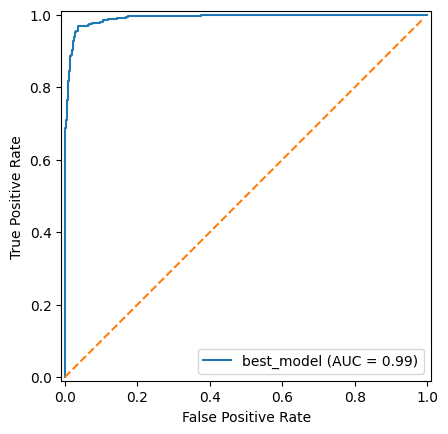

In [47]:
fpr, tpr, thresholds = roc_curve(y_true = y_test, y_score = CBC_ensembles_fit[best_model].predict_proba(X_test)[:, 1])
roc_auc = roc_auc_score(y_true = y_test, y_score = CBC_ensembles_fit[best_model].predict_proba(X_test)[:, 1])
display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, name = 'best_model')
display.plot()
x_plot = [k / len(fpr) for k in range(len(fpr))]
plt.plot(x_plot, x_plot, '--')
plt.show()

### PR-AUC

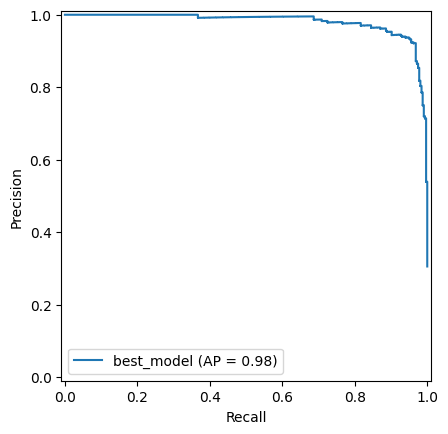

In [48]:
prec, recall, thresholds = precision_recall_curve(y_true = y_test,
                                                  y_score = CBC_ensembles_fit[best_model].predict_proba(X_test)[:, 1])
pr_auc = average_precision_score(y_true = y_test, y_score = CBC_ensembles_fit[best_model].predict_proba(X_test)[:, 1])
pr_display = PrecisionRecallDisplay(precision = prec, recall = recall, average_precision = pr_auc, name = 'best_model')
pr_display.plot()
plt.show()

### Кроссвалидация

In [49]:
cv_dataset = Pool(data = emails_rel_corr.drop(columns = [target]), label = emails_rel_corr[target])
scores = cv(cv_dataset, folds = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = random_seed),
            params = best_params, verbose = False)
scores

Training on fold [0/10]

bestTest = 0.1242230947
bestIteration = 996

Training on fold [1/10]

bestTest = 0.1507126847
bestIteration = 990

Training on fold [2/10]

bestTest = 0.125488131
bestIteration = 998

Training on fold [3/10]

bestTest = 0.1196612498
bestIteration = 997

Training on fold [4/10]

bestTest = 0.1223144855
bestIteration = 999

Training on fold [5/10]

bestTest = 0.1432244847
bestIteration = 992

Training on fold [6/10]

bestTest = 0.1313044048
bestIteration = 995

Training on fold [7/10]

bestTest = 0.1341848648
bestIteration = 999

Training on fold [8/10]

bestTest = 0.1289141259
bestIteration = 998

Training on fold [9/10]

bestTest = 0.1365634684
bestIteration = 995



,iterations,test-CrossEntropy-mean,test-CrossEntropy-std,train-CrossEntropy-mean,train-CrossEntropy-std,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std
0,0,0.676540,0.001043,0.674357,0.001046,0.676540,0.001043,0.674357,0.001046
1,1,0.660506,0.001156,0.656236,0.001484,0.660506,0.001156,0.656236,0.001484
2,2,0.645533,0.002280,0.639133,0.001699,0.645533,0.002280,0.639133,0.001699
3,3,0.631860,0.002908,0.623659,0.002385,0.631860,0.002908,0.623659,0.002385
4,4,0.619128,0.002973,0.608734,0.002196,0.619128,0.002973,0.608734,0.002196
...,...,...,...,...,...,...,...,...,...
995,995,0.131782,0.009768,0.019808,0.001102,0.131782,0.009768,0.019808,0.001102
996,996,0.131749,0.009779,0.019783,0.001100,0.131749,0.009779,0.019783,0.001100
997,997,0.131747,0.009776,0.019764,0.001097,0.131747,0.009776,0.019764,0.001097
998,998,0.131734,0.009826,0.019738,0.001097,0.131734,0.009826,0.019738,0.001097


График сходимости метрики Logloss на обучении и тесте от количества итераций обучения с неопределённостью по стандартному отклонению.

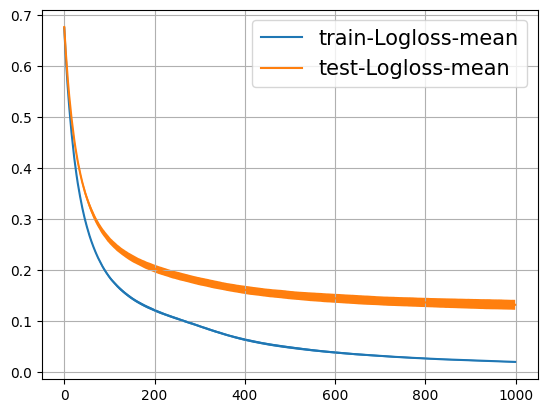

In [50]:
plt.plot(scores.iterations, scores['train-Logloss-mean'], label = 'train-Logloss-mean')
plt.fill_between(scores.iterations,
                 scores['train-Logloss-mean'] - scores['train-Logloss-std'],
                 scores['train-Logloss-mean'] + scores['train-Logloss-std'])
plt.plot(scores.iterations, scores['test-Logloss-mean'], label = 'test-Logloss-mean')
plt.fill_between(scores.iterations,
                 scores['test-Logloss-mean'] - scores['test-Logloss-std'],
                 scores['test-Logloss-mean'] + scores['test-Logloss-std'])
plt.grid()
plt.legend(prop = {'size': 15})
plt.show()

Сравнение метрики Logloss на обучении и тесте на последней итерации с неопределённостью по стандартному отклонению.

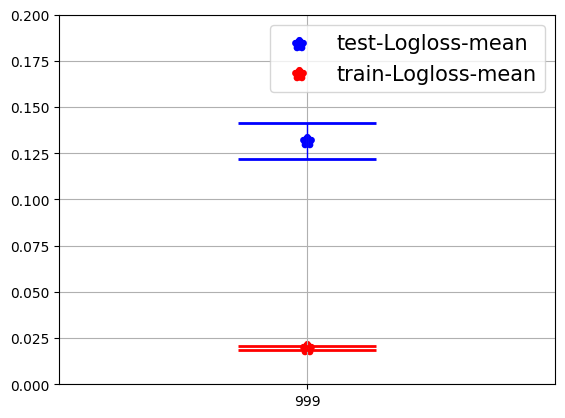

In [51]:
plt.errorbar(scores.iterations.values[-1], scores['test-Logloss-mean'].values[-1], yerr = scores['test-Logloss-std'].values[-1],
             fmt = '*', capsize = 50, ecolor = 'b', elinewidth = 1, markersize = 0, capthick = 2)
plt.errorbar(scores.iterations.values[-1], scores['train-Logloss-mean'].values[-1], yerr = scores['train-Logloss-std'].values[-1],
             fmt = '*', capsize = 50, ecolor = 'r', elinewidth = 1, markersize = 0, capthick = 2)
plt.scatter(scores.iterations.values[-1], scores['test-Logloss-mean'].values[-1],
            label = 'test-Logloss-mean', marker = '*', linewidths = 5, color = 'b')
plt.scatter(scores.iterations.values[-1], scores['train-Logloss-mean'].values[-1],
            label = 'train-Logloss-mean', marker = '*', linewidths = 5, color = 'r')
plt.ylim(0, 0.2)
plt.xticks([scores.iterations.values[-1]])
plt.legend(prop = {'size': 15}, markerscale = 1)
plt.grid()
plt.show()